[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)  
[타이타닉 캐글 링크](https://www.kaggle.com/c/titanic)

# [Introduction to Ensembling/Stacking in Python](https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python)  

# Introduction
This notebook is a very basic and simple introductory primer to the method of ensembling (combining) base learning models, in particular the variant of ensembling known as Stacking. In a nutshell stacking uses as a first-level (base), the predictions of a few basic classifiers and then uses another model at the second-level to predict the output from the earlier first-level predictions.  
  
The Titanic dataset is a prime candidate for introducing this concept as many newcomers to Kaggle start out here. Furthermore even though stacking has been responsible for many a team winning Kaggle competitions there seems to be a dearth of kernels on this topic so I hope this notebook can fill somewhat of that void.  
  
I myself am quite a newcomer to the Kaggle scene as well and the first proper ensembling/stacking script that I managed to chance upon and study was one written in the AllState Severity Claims competition by the great Faron. The material in this notebook borrows heavily from Faron's script although ported to factor in ensembles of classifiers whilst his was ensembles of regressors. Anyway please check out his script here:  
  
[Stacking Starter](https://www.kaggle.com/code/mmueller/stacking-starter) : by Faron  
※ 링크가 사라져서 동일한 유저의 동명의 코드 링크 연결
  
Now onto the notebook at hand and I hope that it manages to do justice and convey the concept of ensembling in an intuitive and concise manner. My other standalone Kaggle script which implements exactly the same ensembling steps (albeit with different parameters) discussed below gives a Public LB score of 0.808 which is good enough to get to the top 9% and runs just under 4 minutes. Therefore I am pretty sure there is a lot of room to improve and add on to that script. Anyways please feel free to leave me any comments with regards to how I can improve  
  
# DeepL 번역
이 노트는 기본 학습 모델을 조합(결합)하는 방법, 특히 스태킹으로 알려진 조합의 변형에 대한 매우 기본적이고 간단한 입문서입니다. 간단히 말해 스태킹은 몇 가지 기본 분류기의 예측을 1레벨(기본)로 사용한 다음 2레벨에서 다른 모델을 사용하여 앞선 1레벨 예측의 결과를 예측하는 방식입니다.  
  
타이타닉 데이터 세트는 이 개념을 도입하기에 가장 적합한 후보입니다. 많은 Kaggle 초보자가 여기서 시작하기 때문입니다. 또한 스태킹은 많은 팀이 Kaggle 대회에서 우승하는 데 기여했음에도 불구하고 이 주제에 대한 커널이 부족한 것 같아서 이 노트북이 그 공백을 어느 정도 메울 수 있기를 바랍니다.  
  
저 역시 Kaggle을 처음 접했고, 우연히 발견하고 공부한 최초의 제대로 된 앙상블/스태킹 스크립트는 위대한 Faron이 올스테이트 심각도 주장 대회에서 작성한 것이었습니다. 이 노트의 자료는 Faron의 스크립트에서 많이 차용했지만, 분류기의 앙상블을 고려하도록 포팅된 반면, 그의 스크립트는 회귀기의 앙상블을 고려했습니다. 어쨌든 그의 스크립트는 여기에서 확인하시기 바랍니다:  
  
[스태킹 스타터](https://www.kaggle.com/code/mmueller/stacking-starter) : Faron 제공  
※ 링크가 사라져서 동일한 유저의 동명의 코드 링크 연결
  
이제 손에 들고 있는 노트북으로 넘어가서 앙상블의 개념을 직관적이고 간결하게 전달할 수 있기를 바랍니다. 아래에서 설명하는 것과 정확히 동일한 앙상블 단계를 구현하는(매개 변수는 다르지만) 다른 독립 실행형 Kaggle 스크립트는 상위 9%에 들기에 충분한 0.808의 공개 LB 점수를 제공하며 4분 미만으로 실행됩니다. 따라서 이 스크립트를 개선하고 추가할 수 있는 여지가 많다고 확신합니다. 어쨌든 개선할 수 있는 방법에 대해 의견을 남겨 주시기 바랍니다.

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)   # 쥬피터 노트북(웹)에서 실행할 때 출력 화면에 바로 뜨게 하는 명령어
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

from sklearn.svm import SVC
from sklearn.model_selection import KFold

# Feature Exploration, Engineering and Cleaning
Now we will proceed much like how most kernels in general are structured, and that is to first explore the data on hand, identify possible feature engineering opportunities as well as numerically encode any categorical features.

In [2]:
# Load in the train and test datasets
path = './input/001_titanic/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


Well it is no surprise that our task is to somehow extract the information out of the categorical variables  
  
### Feature Engineering
  
Here, credit must be extended to Sina's very comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work  
  
[Titanic Best Working Classfier](https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier) : by Sina

In [3]:
full_data = [train, test]

# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tells whether a pssenger had a cabin on the Titanic
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1

# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

# Define function to extract tiltes from passenger names
def get_tilte(name):
    title_search = re.search(' ([A-Za-z]+\.)', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ''

# Create a new feature Title, contating the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_tilte)

# Group all non-common titles into one single grouping 'Rare'
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mile', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map({'female': 0, 'male': 1}).astype(int)

    # Mapping titles
    title_mapping = {'Mr': 1, 'Misss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Mapping Fare
    dataset.loc[dataset['Fare']<=7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare']>7.91)&(dataset['Fare']<=14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare']>14.454)&(dataset['Fare']<=31), 'Fare'] = 2
    dataset.loc[dataset['Fare']>31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    # Mapping Age
    dataset.loc[dataset['Age']<=16, 'Age'] = 0
    dataset.loc[(dataset['Age']>16)&(dataset['Age']<=32), 'Age'] = 1
    dataset.loc[(dataset['Age']>32)&(dataset['Age']<=48), 'Age'] = 2
    dataset.loc[(dataset['Age']>48)&(dataset['Age']<=64), 'Age'] = 3
    dataset.loc[dataset['Age']>64, 'Age'] = 4;

In [4]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

All right so now having cleaned the features and extracted relevant information and dropped the categorical columns our features should now all be numeric, a format suitable to feed into our Machine Learning models. However before we proceed let us generate some simple correlation and distribution plots of our transformed dataset to observe ho  
  
## Visualisations

In [5]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,0.0
1,1,1,0,2,0,3,1,51,1,2,0,0.0
2,1,3,0,1,0,1,0,22,0,1,1,0.0


### Pearson Correlation Heatmap
  
let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows

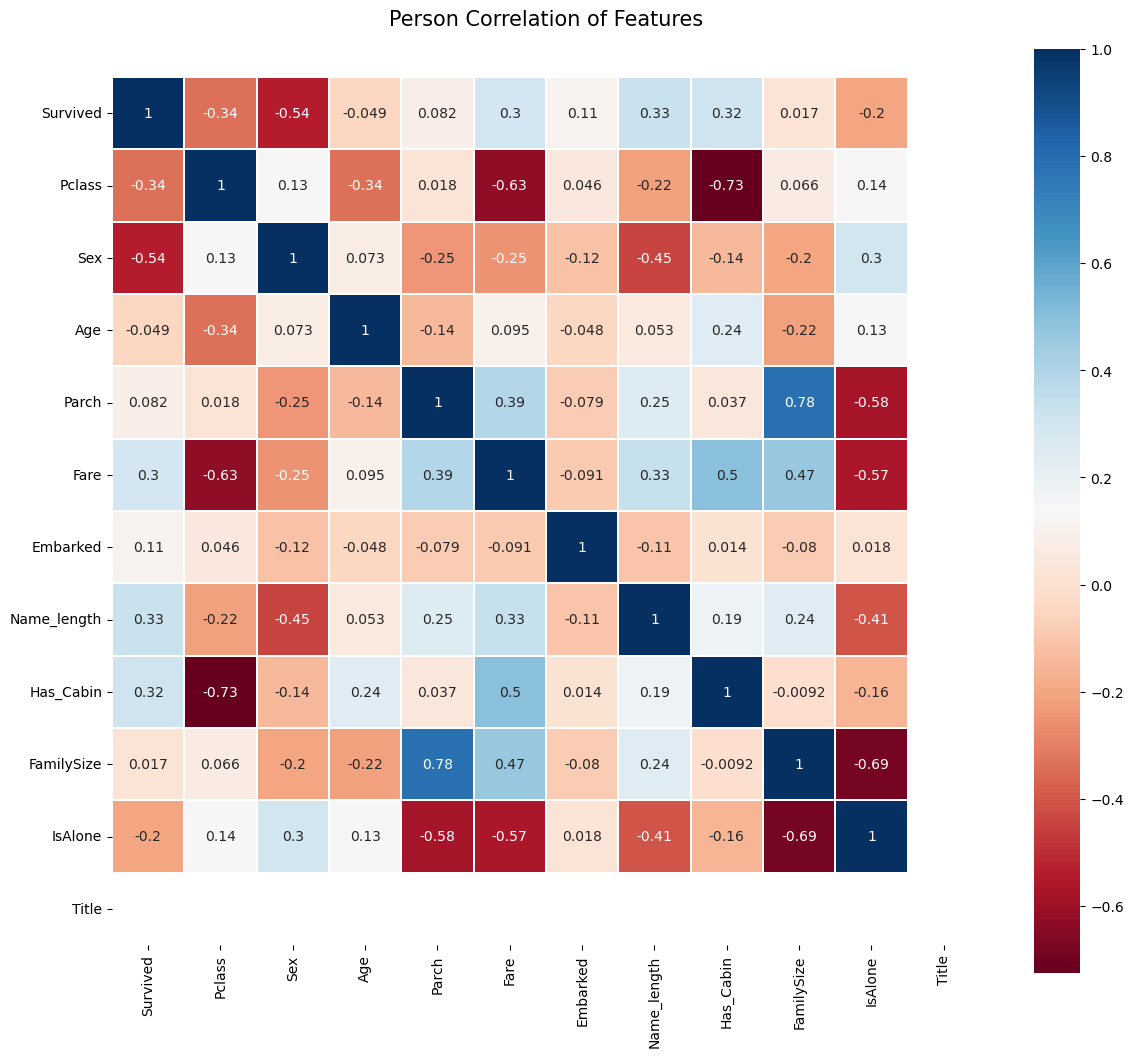

In [6]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Person Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True);

### Takeaway from the Plots
One thing that that the Pearson Correlation plot can tell us is that there are not too many features strongly correlated with one another. This is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. Here are two most correlated features are that of Family size and Parch (Parents and Children). I'll still leave both features in for the purposes of this exercise.  
  
### Pairplots
Finally let us generate some pairplots to observe the distribution of data from one feature to the other. Once again we use Seaborn to help us.  
  
### DeepL 번역
피어슨 상관관계 도표에서 알 수 있는 한 가지는 서로 강한 상관관계가 있는 특징이 너무 많지 않다는 것입니다. 이는 학습 모델에 이러한 특징을 입력하는 관점에서 좋은데, 이는 학습 세트에 중복되거나 불필요한 데이터가 많지 않고 각 특징이 고유한 정보를 가지고 있다는 것을 의미하기 때문입니다. 가장 상관관계가 높은 두 가지 기능은 가족 크기와 Parch(부모와 자녀)입니다. 이 연습의 목적을 위해 두 기능을 모두 그대로 유지하겠습니다.  
  
### 페어플롯
마지막으로 한 피처에서 다른 피처로의 데이터 분포를 관찰하기 위해 몇 가지 페어플롯을 생성해 보겠습니다. 다시 한 번 Seaborn의 도움을 받겠습니다.

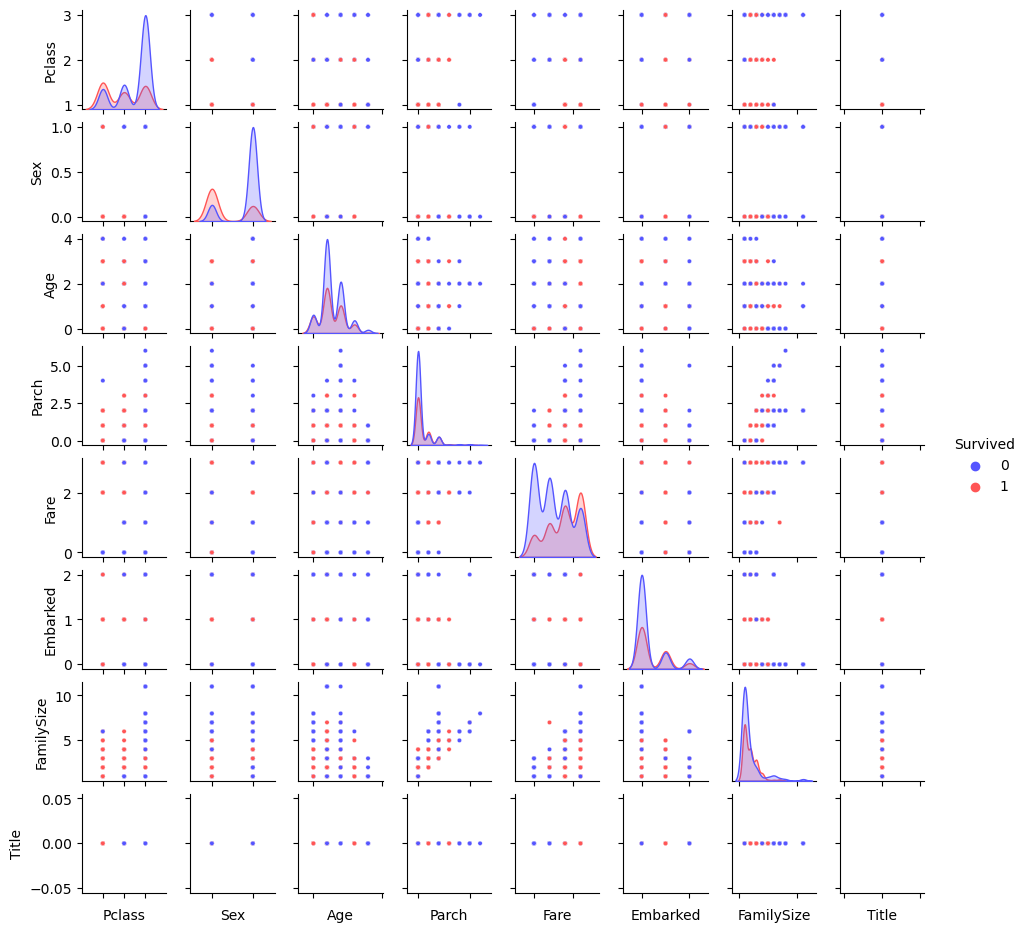

In [7]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
                        u'FamilySize', u'Title']], hue='Survived', palette='seismic', size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
# u-sting: 유니코드 문자열(python2에서 주로 쓰였으며 현재는 거의 불요). b-string: 바이트 문자열.
g.set(xticklabels=[]);

# Ensembling & Stacking models
Finally after that brief whirlwind detour with regards to feature engineering and formatting, we finally arrive at the meat and gist of the this notebook.  
  
Creating a Stacking ensemble!  
  
### Helpers via Python Classes
Here we invoke the use of Python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears Classes being used in conjunction with Object-Oriented Programming (OOP). In short, a class helps to extend some code/program for creating objects (variables for old-school peeps) as well as to implement functions and methods specific to that class.  
  
In the section of code below, we essentially write a class SklearnHelper that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as won't need to write the same methods five times if we wanted to invoke five different classifiers.  
  
# DeepL 번역
피쳐 엔지니어링 및 서식과 관련하여 잠시 우회한 후 마침내 이 노트북의 핵심에 도달했습니다.  
  
스태킹 앙상블 만들기!  
  
### Helpers via Python Classes
여기서는 파이썬의 클래스를 사용하여 보다 편리하게 작업할 수 있도록 돕습니다. 프로그래밍을 처음 접하는 사람이라면 보통 클래스가 객체 지향 프로그래밍(OOP)과 함께 사용된다는 말을 듣게 됩니다. 간단히 말해, 클래스는 객체를 생성하기 위한 일부 코드/프로그램을 확장하고(구식 사용자에게는 변수) 해당 클래스에 특정한 함수 및 메서드를 구현하는 데 도움이 됩니다.  
  
아래 코드 섹션에서는 기본적으로 모든 Sklearn 분류기에 공통적으로 내장된 메서드(예: 훈련, 예측, 적합)를 확장할 수 있는 SklearnHelper 클래스를 작성합니다. 따라서 5개의 서로 다른 분류기를 호출하려는 경우 동일한 메서드를 5번 작성할 필요가 없으므로 중복성을 제거할 수 있습니다.

In [8]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0    # for repreoducibility
NFOLDS = 5  # set folds for out-of-fold prediction
# kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)
# 함수가 변경되어 train을 나중에 .split 메서드에 입력
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        if type(self.clf)==SVC:             # 노트북엔 없지만 SVC용으로 작성
            print(self.clf.fit(x, y).coef_)
            return self.clf.fit(x, y).coef_ # 노트북에선 값을 수기로 기입하여 코드 작성
        else:
            print(self.clf.fit(x, y).feature_importances_)
            return self.clf.fit(x, y).feature_importances_

# Class to extend XGboost classifier

Bear with me for those who already know this but for people who have not created classes or objects in Python before, let me explain what the code given above does. In creating my base classifiers, I will only use the models already present in the Sklearn library and therefore only extend the class for that.  
  
__def init__ : Python standard for invoking the default constructor for the class. This means that when you want to create an object (classifier), you have to give it the parameters of clf (what sklearn classifier you want), seed (random seed) and params (parameters for the classifiers).  
  
The rest of the code are simply methods of the class which simply call the corresponding methods already existing within the sklearn classifiers. Essentially, we have created a wrapper class to extend the various Sklearn classifiers so that this should help us reduce having to write the same code over and over when we implement multiple learners to our stacker.  
  
### Out-of-Fold Predictions
Now as alluded to above in the introductory section, stacking uses predictions of base classifiers as input for training to a second-level model. However one cannot simply train the base models on the full training data, generate predictions on the full test set and then output these for the second-level training. This runs the risk of your base model predictions already having "seen" the test set and therefore overfitting when feeding these predictions.  
  
__DeepL 번역__  
이미 알고 계신 분들은 이해하시겠지만, 파이썬에서 클래스나 객체를 생성해 본 적이 없는 분들을 위해 위에 제공된 코드가 무엇을 하는지 설명해 드리겠습니다. 기본 분류자를 만들 때는 Sklearn 라이브러리에 이미 있는 모델만 사용하므로 이를 위해 클래스만 확장할 것입니다.  
  
__def init__: 클래스의 기본 생성자를 호출하기 위한 Python 표준입니다. 즉, 객체(분류자)를 생성하려면 clf(원하는 Sklearn 분류자), seed(무작위 시드) 및 params(분류자의 매개 변수)의 매개 변수를 제공해야 합니다.  
  
나머지 코드는 단순히 클래스의 메서드이며, 스클레인 분류기 내에 이미 존재하는 해당 메서드를 호출하기만 하면 됩니다. 기본적으로 다양한 Sklearn 분류기를 확장하기 위해 래퍼 클래스를 만들었기 때문에 스태커에 여러 학습자를 구현할 때 동일한 코드를 반복해서 작성해야 하는 번거로움을 줄일 수 있습니다.  
  
### Out-of-Fold Predictions
위에서 소개 섹션에서 언급했듯이 스태킹은 기본 분류기의 예측을 두 번째 수준 모델 학습을 위한 입력으로 사용합니다. 그러나 단순히 전체 훈련 데이터에 대해 기본 모델을 훈련하고 전체 테스트 세트에 대해 예측을 생성한 다음 이를 2단계 훈련에 출력할 수는 없습니다. 이렇게 하면 기본 모델 예측이 이미 테스트 세트를 “본” 상태이므로 이러한 예측을 입력할 때 과적합의 위험이 있습니다.

In [9]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain, ))
    oof_test = np.zeros((ntest, ))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models
So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:  
  
1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine
  
__Parameters__  
  
Just a quick summary of the parameters that we will be listing here for completeness,  
  
__n_jobs__ : Number of cores used for the training process. If set to -1, all cores are used.  
  
__n_estimators__ : Number of classification trees in your learning model ( set to 10 per default)  
  
__max_depth__ : Maximum depth of tree, or how much a node should be expanded. Beware if set to too high a number would run the risk of overfitting as one would be growing the tree too deep  
  
__verbose__ : Controls whether you want to output any text during the learning process. A value of 0 suppresses all text while a value of 3 outputs the tree learning process at every iteration.  
  
Please check out the full description via the official Sklearn website. There you will find that there are a whole host of other useful parameters that you can play around with.  
  
## DeepL 번역
이제 첫 번째 수준 분류로 5개의 학습 모델을 준비하겠습니다. 이러한 모델은 모두 Sklearn 라이브러리를 통해 편리하게 호출할 수 있으며 다음과 같이 나열되어 있습니다:  
  
1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifer
4. Gradient Boosting classifer
5. Support Vector Machine
  
__파라미터__  
  
완성도를 위해 여기에 나열할 파라미터를 간단히 요약하면 다음과 같습니다,  
  
__n_jobs__ : 훈련 프로세스에 사용되는 코어 수입니다. -1로 설정하면 모든 코어가 사용됩니다.  
  
__n_estimators__ : 학습 모델에 포함된 분류 트리의 수(기본값은 10개로 설정)  
  
__max_depth__ : 트리의 최대 깊이 또는 노드를 얼마나 확장할지 설정합니다. 너무 높은 값으로 설정하면 트리가 너무 깊게 성장하여 과적합의 위험이 있으므로 주의하세요.  
  
__verbose__ : 학습 과정에서 텍스트를 출력할지 여부를 제어합니다. 값이 0이면 모든 텍스트를 출력하지 않고, 값이 3이면 모든 반복마다 트리 학습 과정을 출력합니다.  
  
자세한 설명은 공식 Sklearn 웹사이트에서 확인하세요. 거기에는 다양한 유용한 매개변수를 사용할 수 있습니다.

In [10]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    # 'max_features':0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    # 'max_features':0.2,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    # 'max_features':0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Surpport Vector Classifier parameters
svc_params = {
    'kernel': 'linear',
    'C': 0.025
    }

Furthermore, since having mentioned about Objects and classes within the OOP framework, let us now create 5 objects that represent our 5 learning models via our Helper Sklearn Class we defined earlier.

In [11]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating NumPy arrays out of our train and test sets
  
Great. Having prepared our first layer base models as such, we can now ready the training and test test data for input into our classifiers by generating NumPy arrays out of their original dataframes as follows:

In [12]:
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train['Survived'].ravel() # df.ravle = np.ravel: np.flatten과 같은 기능이지만 memory 공유
train = train.drop(['Survived'], axis=1)
x_train = train.values  # Create an arrays an array of the train data
x_test = test.values    # Create an arrays an array of the test data

### Output of the First level Predictions
  
We now feed the training and test data into our 5 base classifiers and use the Out-of-Fold prediction function we defined earlier to generate our first level predictions. Allow a handful of minutes for the chunk of code below to run.

In [13]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)   # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)   # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)   # AdaBoost
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)   # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)   # Support Vector Classifier

print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers
  
Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.  
  
As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in __.featureimportances__. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such  
  
### DeepL 번역
이제 1단계 분류자를 배웠으므로, Sklearn 모델의 매우 멋진 기능을 활용할 수 있으며, 이는 매우 간단한 코드 한 줄로 훈련 및 테스트 세트에 있는 다양한 특징의 임포텐셜을 출력하는 것입니다.  
  
Sklearn 설명서에 따르면, 대부분의 분류기에는 __.featureimportances를__ 입력하기만 하면 기능 중요도를 반환하는 속성이 내장되어 있습니다. 따라서 함수 ear를 통해 이 매우 유용한 속성을 호출하고 다음과 같이 특징 중요도를 플롯하겠습니다.

In [14]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)
svc_feature = svc.feature_importances(x_train, y_train) # 없기에 만듦

[0.11214206 0.38866492 0.05255658 0.02691783 0.05691486 0.03902872
 0.18335062 0.06320136 0.0611205  0.01610256 0.        ]
[0.13262437 0.48728342 0.03992059 0.02143935 0.06607146 0.03161831
 0.06292182 0.09202163 0.04126947 0.02482959 0.        ]
[0.028 0.01  0.02  0.068 0.034 0.006 0.754 0.006 0.068 0.006 0.   ]
[0.11513164 0.38161011 0.07272483 0.02102726 0.050657   0.0264372
 0.20327065 0.04814828 0.074939   0.00605403 0.        ]
[[-0.14822775 -1.60842339 -0.14104641  0.15278763  0.03027741  0.09635085
   0.01489985  0.15361047 -0.21461183 -0.23260055  0.        ]]


So I have not yet figured out how to assign and store the feature importances outright. Therefore I'll print out the values from the code above and then simply copy and paste into Python lists as below (sorry for the lousy hack)

In [15]:
## 노트북은 직접 복붙했지만 코드를 수정했기 때문에 전부 주석 처리

# rf_features = [0.11222363, 0.39399656, 0.05025263, 0.02752683, 0.05672399, 0.03891586,
#                0.18097295, 0.06186366, 0.06180563, 0.01571827, 0.]
# et_features = [0.13320324, 0.48873894, 0.03687849, 0.02125097, 0.06672764, 0.03129308,
#                0.06354942, 0.09309982, 0.04049958, 0.02475883, 0.]
# ada_features = [0.024, 0.01, 0.022, 0.066, 0.034, 0.008, 0.758, 0.006, 0.07, 0.002, 0.]
# gb_features = [0.1184836, 0.37508632, 0.06650689, 0.02395207, 0.05696399, 0.03310011,
#                0.20482562, 0.04653653, 0.06320996, 0.01133491, 0.]
# svc_features = [[-0.1325155 -1.63736263 -0.12697486, 0.14230097, 0.03048044, 0.08579841,
#                  0.01387737, 0.14694269 -0.20209655 -0.21916169, 0.]]

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [16]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame({'features': cols,
                                  'Random Forest feature importances': rf_feature,  # 노트북은 features지만 함수로 할당했기에 feature 기업
                                  'Extra Trees feature importances': et_feature,
                                  'AdaBoost feature importances': ada_feature,
                                  'Gradient Boost feature importances': gb_feature,
                                  'Support Vector Classifier feature importances': abs(svc_feature[0]),
                                  })

### Interactive feature importances via Plotly scatterplots
  
I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers via a plotly scatter plot by calling "Scatter" as follows:

In [17]:
feature_dataframe.columns

Index(['features', 'Random Forest feature importances',
       'Extra Trees feature importances', 'AdaBoost feature importances',
       'Gradient Boost feature importances',
       'Support Vector Classifier feature importances'],
      dtype='object')

In [18]:
# # Scatter plot
# trace = go.Scatter(
#     y = feature_dataframe['Random Forest feature importances'].values,
#     x = feature_dataframe['features'].values,
#     mode='markers',
#     marker=dict(
#         sizemode='diameter',
#         sizeref=1,
#         size=25,
#         # size=feature_dataframe['AdaBoost feature importances'].values,
#         # color=np.random.randn(500), # set color equal to a variable
#         color=feature_dataframe['Random Forest feature importances'].values,
#         colorscale='Portland',
#         showscale=True
#     ),
#     text=feature_dataframe['features'].values
# )
# data = [trace]

# layout = go.Layout(
#     autosize=True,
#     title='Random Forest Feature Importance',
#     hovermode='closest',
#     # xaxis=dict(
#     #     tilte='Pop',
#     #     ticklen=5,
#     #     zeroline=False,
#     #     gridwidth=2
#     # ),
#     yaxis=dict(
#         title='Feature Importance',
#         ticklen=5,
#         gridwidth=2
#     ),
#     showlegend=False
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='scatter2010')

# # Scatter plot
# trace = go.Scatter(
#     y=feature_dataframe['Extra Trees feature importances'].values,
#     x=feature_dataframe['features'].values,
#     mode='markers',
#     marker=dict(
#         sizemode='diameter',
#         sizeref=1,
#         size=25,
#         # size=feature_dataframe['AdaBoost feature importances'].values,
#         # color=np.random.randn(500), # set color equal to a variable
#         color=feature_dataframe['Extra Trees feature importances'].values,
#         colorscale='Portland',
#         showscale=True
#     ),
#     text=feature_dataframe['features'].values
# )
# data = [trace]

# layout = go.Layout(
#     autosize=True,
#     title='Extra Trees Feature Importance',
#     hovermode='closest',
#     # xaxis=dict(
#     #     tilte='Pop',
#     #     ticklen=5,
#     #     zeroline=False,
#     #     gridwidth=2
#     # ),
#     yaxis=dict(
#         title='Feature Importance',
#         ticklen=5,
#         gridwidth=2
#     ),
#     showlegend=False
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='scatter2010')

# # Scatter plot
# trace = go.Scatter(
#     y=feature_dataframe['AdaBoost feature importances'].values,
#     x=feature_dataframe['features'].values,
#     mode='markers',
#     marker=dict(
#         sizemode='diameter',
#         sizeref=1,
#         size=25,
#         # size=feature_dataframe['AdaBoost feature importances'].values,
#         # color=np.random.randn(500), # set color equal to a variable
#         color=feature_dataframe['AdaBoost feature importances'].values,
#         colorscale='Portland',
#         showscale=True
#     ),
#     text=feature_dataframe['features'].values
# )
# data = [trace]

# layout = go.Layout(
#     autosize=True,
#     title='AdaBoost Feature Importance',
#     hovermode='closest',
#     # xaxis=dict(
#     #     tilte='Pop',
#     #     ticklen=5,
#     #     zeroline=False,
#     #     gridwidth=2
#     # ),
#     yaxis=dict(
#         title='Feature Importance',
#         ticklen=5,
#         gridwidth=2
#     ),
#     showlegend=False
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='scatter2010')

# # Scatter plot
# trace = go.Scatter(
#     y=feature_dataframe['Gradient Boost feature importances'].values,
#     x=feature_dataframe['features'].values,
#     mode='markers',
#     marker=dict(
#         sizemode='diameter',
#         sizeref=1,
#         size=25,
#         # size=feature_dataframe['AdaBoost feature importances'].values,
#         # color=np.random.randn(500), # set color equal to a variable
#         color=feature_dataframe['Gradient Boost feature importances'].values,
#         colorscale='Portland',
#         showscale=True
#     ),
#     text=feature_dataframe['features'].values
# )
# data = [trace]

# layout = go.Layout(
#     autosize=True,
#     title='Gradient Boosting Feature Importance',
#     hovermode='closest',
#     # xaxis=dict(
#     #     tilte='Pop',
#     #     ticklen=5,
#     #     zeroline=False,
#     #     gridwidth=2
#     # ),
#     yaxis=dict(
#         title='Feature Importance',
#         ticklen=5,
#         gridwidth=2
#     ),
#     showlegend=False
# )
# fig = go.Figure(data=data, layout=layout)
# py.iplot(fig, filename='scatter2010')


###################################################
# 상기 내용 반복문 작성
for col in feature_dataframe.columns[1:]:
    # Scatter plot
    trace = go.Scatter(
        y = feature_dataframe[col].values,
        x = feature_dataframe['features'].values,
        mode='markers',
        marker=dict(
            sizemode='diameter',
            sizeref=1,
            size=25,
            color=feature_dataframe[col].values,
            colorscale='Portland',
            showscale=True
        ),
        text=feature_dataframe['features'].values
    )
    data = [trace]

    layout = go.Layout(
        autosize=True,
        title=col,
        hovermode='closest',
        yaxis=dict(
            title='Feature Importance',
            ticklen=5,
            gridwidth=2
        ),
        showlegend=False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='scatter2010')

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe.

In [19]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis=1, numeric_only=True)  # axis=1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,Support Vector Classifier feature importances,mean
0,Pclass,0.112142,0.132624,0.028,0.115132,0.148228,0.107225
1,Sex,0.388665,0.487283,0.010,0.381610,1.608423,0.575196
2,Age,0.052557,0.039921,0.020,0.072725,0.141046,0.065250


### Plotly Barplot of Average Feature Importances
  
Having obtained the mean feature importance across all our classifiers, we can plot them into a Plotly bar plot as follows:

In [20]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(x=x,
               y=y,
               width=0.5,
               marker=dict(
                   color=feature_dataframe['mean'].values,
                   colorscale='Portland',
                   reversescale=False
               ),
               opacity=0.6
               )]

layout = go.Layout(
    autosize=True,
    title='Barplots of Mean Feature Importance',
    hovermode='closest',
    # xaxis=dict(
    #     title='Pop',
    #     ticklen=5,
    #     zeroline=False,
    #     gridwidth=2,
    # ),
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False,
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(coloraxis_showscale=True)
py.iplot(fig, filename='bar-direct-labels')

# Second-Level Predictions from the First-level Output
### First-level output as new features
  
Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.  
  
# DeepL 번역
  
이제 1단계 예측을 얻었으므로, 다음 분류기의 학습 데이터로 사용할 새로운 특징 집합을 구축하는 것으로 생각할 수 있습니다. 따라서 아래 코드에 따라 이전 분류기의 1단계 예측을 새 열로 사용하고 이를 기반으로 다음 분류기를 훈련합니다.

In [21]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                       'ExtraTrees': et_oof_train.ravel(),
                                       'AdaBoost': ada_oof_train.ravel(),
                                       'GradientBoost': gb_oof_train.ravel(),
                                       'SupportVector': svc_oof_train.ravel(),
                                       })
base_predictions_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost,SupportVector
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set

In [22]:
data = [
    go.Heatmap(
        z=base_predictions_train.astype(float).corr().values,
        x=base_predictions_train.columns.values,
        y=base_predictions_train.columns.values,
        colorscale='Viridis',
        showscale=True,
        reversescale=True
    )
]

layout = go.Layout(title='Annotated Heatmap')

py.iplot(data, filename='labelled-heatmap');

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

In [23]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

https://www.kaggle.com/code/arthurtok/introduction-to-ensembling-stacking-in-python